In [1]:
from utilities import input_tools
from wremnants import plot_tools
import matplotlib as mpl
import numpy as np
from utilities import boostHistHelpers as hh

Welcome to JupyROOT 6.28/06


In [2]:
res, meta, _ = input_tools.read_infile("/scratch/dwalter/results_histmaker/230907_ew_closure/w_z_gen_dists.hdf5")

In [3]:
res.keys()

dict_keys(['WplusToMuNu_winhac-nlo', 'WminusToMuNu_horace-qed', 'ZToMuMu_horace-qed', 'WplusToMuNu_winhac-lo-photos', 'WplusToMuNu_winhac-lo', 'WminusToMuNu_horace-lo-photos', 'WminusToMuNu_horace-nlo', 'WminusToMuNu_winhac-nlo', 'ZToMuMu_horace-lo-photos', 'WplusToMuNu_horace-lo-photos', 'WplusToMuNu_horace-nlo', 'ZToMuMu_horace-nlo', 'WplusToMuNu_horace-qed', 'WminusToMuNu_winhac-lo-photos', 'WminusToMuNu_winhac-lo', 'meta_info'])

In [4]:
xaxis_labels = {
    "ewLepPt1": r"$p_\mathrm{T}^{\ell_1}$",
    "ewLepPt2": r"$p_\mathrm{T}^{\ell_2}$",
    "ewLepEta1": r"$\eta^{\ell_1}$",
    "ewLepEta2": r"$\eta^{\ell_2}$",
}

In [262]:
# settings:
base_process = "WplusToMuNu"
# base_process = "WminusToMuNu"
# base_process = "ZToMuMu"
# generator = "winhac" 
generator = "horace"
generatorNLO = "horace"
process = f"{base_process}_{generator}"
processNLO = f"{base_process}_{generatorNLO}"
var = "ewLepEta1"
showFlow = False
flow=True
colors = mpl.colormaps["tab10"]
text_dict = {
    "ZToMuMu": r"$\mathrm{Z}\rightarrow\mu\mu$",
    "WplusToMuNu": r"$\mathrm{W}^+\rightarrow\mu\nu$",
    "WminusToMuNu": r"$\mathrm{W}^-\rightarrow\mu\nu$"
}
plotname = f"{process}{var}"


In [263]:
def load(process, order, var, appendix="", idx=None):
    proc_name = f"{process}-{order}"
    histo = res[proc_name]['output'][f"nominal_{var}{appendix}"].get()
    if idx is not None:
        histo = histo[...,idx]
    histo = hh.scaleHist(histo, res[proc_name]["dataset"]["xsec"]*10e6/res[proc_name]['weight_sum'], createNew=True)
    return histo


In [264]:
hLO_Uncorr = load(process, "lo-photos", var)
hLO_Corr = load(process, "lo-photos", var, appendix="_horacenloewCorr", idx=1)
hNLO = load(processNLO, "nlo", var)


In [265]:
h1ds = [hLO_Uncorr, hLO_Corr, hNLO]

In [266]:
hratios1D = [hh.divideHists(h1d, h1ds[-1]) for h1d in h1ds[:-1]]

In [267]:
def plot(h1ds, ratio=False):
    
    labels = [f"{generator} LO",f"{generator} " + r"LO $\times$ Corr(Horace)", f"{generatorNLO} NLO"]
    linestyles = ["-", "--", ":"]
    
    if ratio:
        ylabel=f"1./{labels[-1]}"
    else:
        ylabel="a.u."
    
    ymin = None if ratio else 0
    ymax = None

    ymax = ymax if ymax is not None else max([max(h.values(flow=showFlow)) for h in h1ds])
    ymin = ymin if ymin is not None else min([min(h.values(flow=showFlow)) for h in h1ds])
    yrange = ymax - ymin
    ymin = ymin if ymin == 0 else ymin - yrange*0.3
    ymax = ymax + yrange*0.3

    fig, ax = plot_tools.figure(hNLO, 
                      xlabel=xaxis_labels[var], ylabel=ylabel, cms_label="Preliminary", 
                      automatic_scale=False, width_scale=1.2,ylim=(ymin, ymax))
    if ratio:
        x = h1ds[0].axes.edges[0][:-1]
        ax.plot([min(x), max(x)], [1,1], color="black", linestyle="--")
    
    for i, h1d in enumerate(h1ds):
        x = h1d.axes.edges[0][:-1]
        y = h1d.values(flow=flow)
        err = np.sqrt(h1d.variances(flow=flow))

        ax.set_xlim((min(x),max(x)))
        ax.set_ylim((ymin,ymax))

        if flow:
            # add extra bin with bin wdith of 1% of total width
            rangex = x[-1] - x[0]

            if h1d.axes[0].traits.underflow:
                x = np.insert(x, 0, x[0] - rangex*0.02)
            if h1d.axes[0].traits.overflow:
                x = np.append(x, x[-1] + rangex*0.02)

        if showFlow:
            ax.set_xlim((min(x),max(x)))
        
#         ax.set_xlim(26,56)#-2.4,2.4)

        ax.step(x, y, color=colors(i), linestyle=linestyles[i], label=labels[i], where="post")
    #     ax.fill_between(x, y - err, y + err, alpha=0.3, color=colors(i), step="post")

    ax.text(1.0, 1.003, text_dict[base_process], transform=ax.transAxes, fontsize=30,
            verticalalignment='bottom', horizontalalignment="right")
    plot_tools.addLegend(ax, ncols=2, text_size=12)
    if ratio:
        plot_name = plotname+"_ratio"
    else:
        plot_name = plotname
    plot_tools.save_pdf_and_png("./", plot_name)

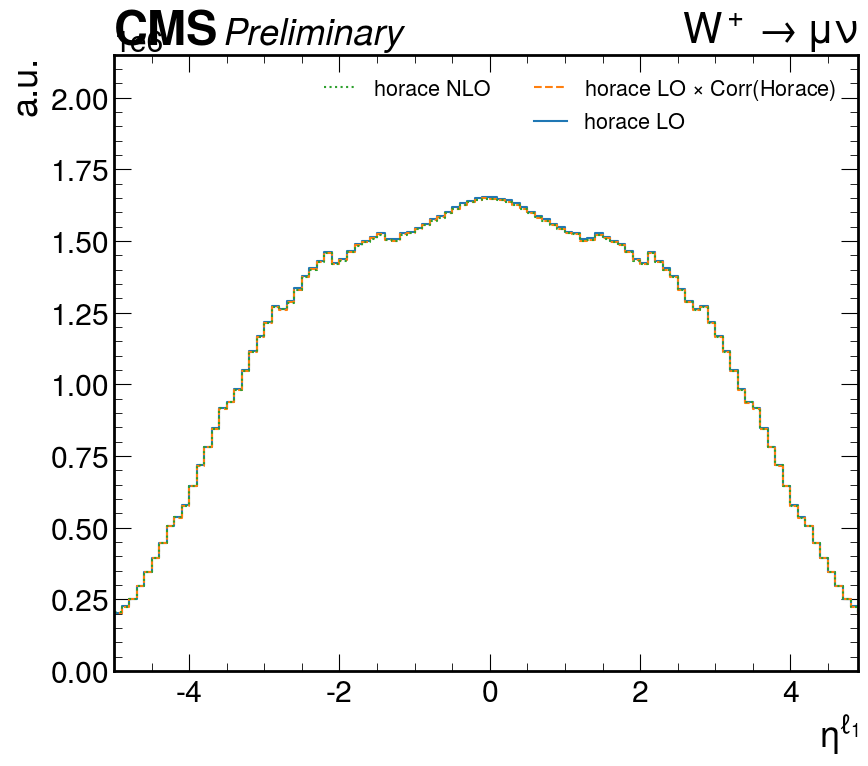

In [268]:
plot(h1ds)

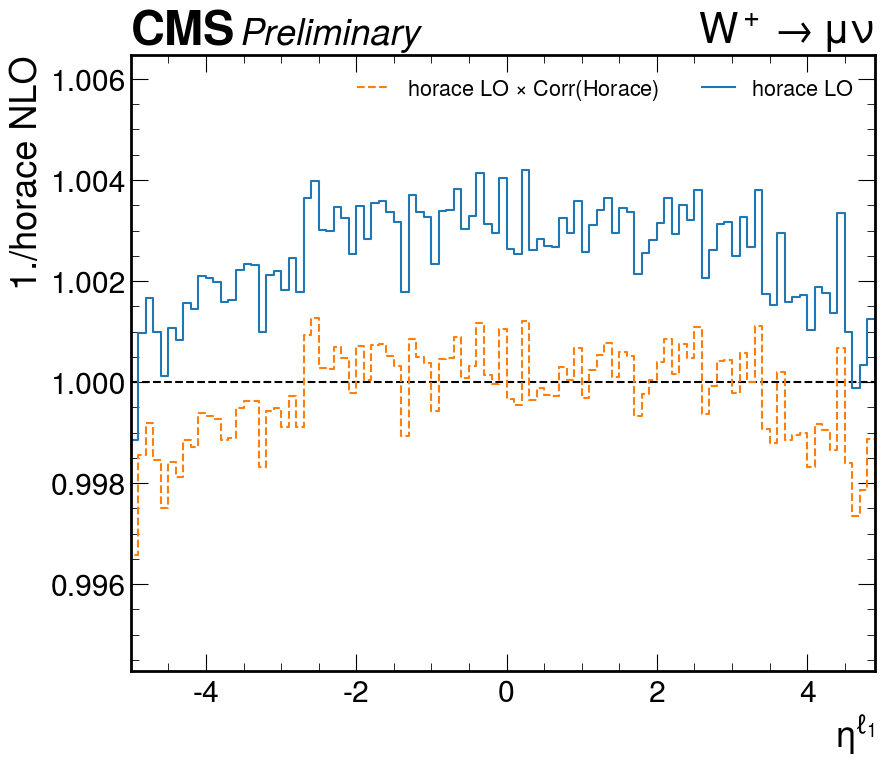

In [269]:
plot(hratios1D, True)